In [4]:
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Read datasets
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_train = pd.read_csv("order_products__train.csv")
order_test = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [6]:
# Merge datasets
order = order_train.merge(orders, on=['order_id'])
order = order.merge(products, on=['product_id'])
order = order.merge(aisles, on=['aisle_id'])
order_df = order.merge(departments, on=['department_id'])
order_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [7]:
# Remove columns not needed
order_df = order_df.drop(columns = ['eval_set', 'order_number','order_dow'], axis =1)
order_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,41425,8,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,187205,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [52]:
# Check If There Are Repeat Customers
# Groupby User, Product ID and Product Name
top_user = order_df.groupby(['user_id','product_id','product_name']).size().reset_index(name = "count")
top_user = pd.DataFrame(top_user)

# Unique Values in Count Are 1 Meaning This Dataset is of Unique Customers
len(pd.unique(top_user['count']))

1

In [53]:
# Print Number of Aisles and Departments
print( len(pd.unique(order_df['aisle'])), len(pd.unique(order_df['department'])))

# Not many departments compare to aisles, to have our clusters be more details we'll focus on
# aisles for cluster customer segments

134 21


## Top Products in Aisle

In [84]:
# TOP Products in Aisle
top_aisle = order_df.groupby(['aisle_id','aisle','product_id','product_name']).size().reset_index(name = "count")
top_aisle = pd.DataFrame(top_aisle)
top_aisle.head()

,aisle_id,aisle,product_id,product_name,count
0,1,prepared soups salads,209,Italian Pasta Salad,8
1,1,prepared soups salads,554,Turkey Chili,56
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,1
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,5
4,1,prepared soups salads,2539,Original Potato Salad,33


In [91]:
# TOP 3 Products in Aisle
# Sort Descending on Count
top_aisle = top_aisle.sort_values(by='count', ascending = False)

# Sort Ascending on Aisle
top_aisle = top_aisle.sort_values(by='aisle_id')

# Get Unique aisle_id List
unique_aisle = pd.unique(top_aisle['aisle_id'])

# Get initial dataframe to concat
inital_df = top_aisle.loc[top_aisle['aisle_id'] == unique_aisle[0]].nlargest(3, columns='count')

# Creat for loop to concat top 3 product of each aisle
for i in range(1,len(unique_aisle)):
    top_3 = top_aisle.loc[top_aisle['aisle_id'] == unique_aisle[i]].nlargest(3, columns='count')
    inital_df = pd.concat([inital_df,top_3])
    
top3_aisle = inital_df
top3_aisle.head()

,aisle_id,aisle,product_id,product_name,count
61,1,prepared soups salads,26047,Tuna Salad,208
57,1,prepared soups salads,25199,Classic Chicken Salad,200
50,1,prepared soups salads,22281,Chicken Noodle Soup,165
293,2,specialty cheeses,37524,Fresh Mozzarella Ball,450
194,2,specialty cheeses,13409,Dubliner Wedge Pre Cut Cheese,253


In [118]:
# List of Repeated Purchases
reorder = order_df[order_df['reordered']==1]
reorder_df = reorder[['product_id', 'user_id', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department']]
reorder_df.head()

,product_id,user_id,product_name,aisle_id,department_id,aisle,department
0,49302,112108,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,49302,47901,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,49302,2993,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,49302,41425,Bulgarian Yogurt,120,16,yogurt,dairy eggs
5,49302,199120,Bulgarian Yogurt,120,16,yogurt,dairy eggs


## Model (K-Means)

In [103]:
# Transform Table to be Percentage of Aisle Purchases For User
# Calculate Percentage of User
percent_user = order_df.groupby(['user_id','aisle_id','aisle']).size().reset_index(name='count')

sum_userproduct = percent_user.groupby(['user_id'])['count'].sum().reset_index(name='sum')

# Merge two count and sum dataset to calculate aisle percentage
percent_user = percent_user.merge(sum_userproduct, on='user_id')
percent_user['percent'] = percent_user['count']/percent_user['sum']
percent_user.head()

,user_id,aisle_id,aisle,count,sum,percent
0,1,21,packaged cheese,1,11,0.090909
1,1,23,popcorn jerky,1,11,0.090909
2,1,45,candy chocolate,1,11,0.090909
3,1,53,cream,1,11,0.090909
4,1,54,paper goods,1,11,0.090909


In [104]:
# Create user product aisle percentage table
percent_df = pd.pivot_table(percent_user, values='percent', index='user_id', columns = 'aisle', fill_value = 0 )
percent_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.111111,0.222222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000


In [128]:
# Model K-means
from sklearn.cluster import KMeans

distortions = []
for k in range(1,15):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(percent_df)
    distortions.append(kmeanModel.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


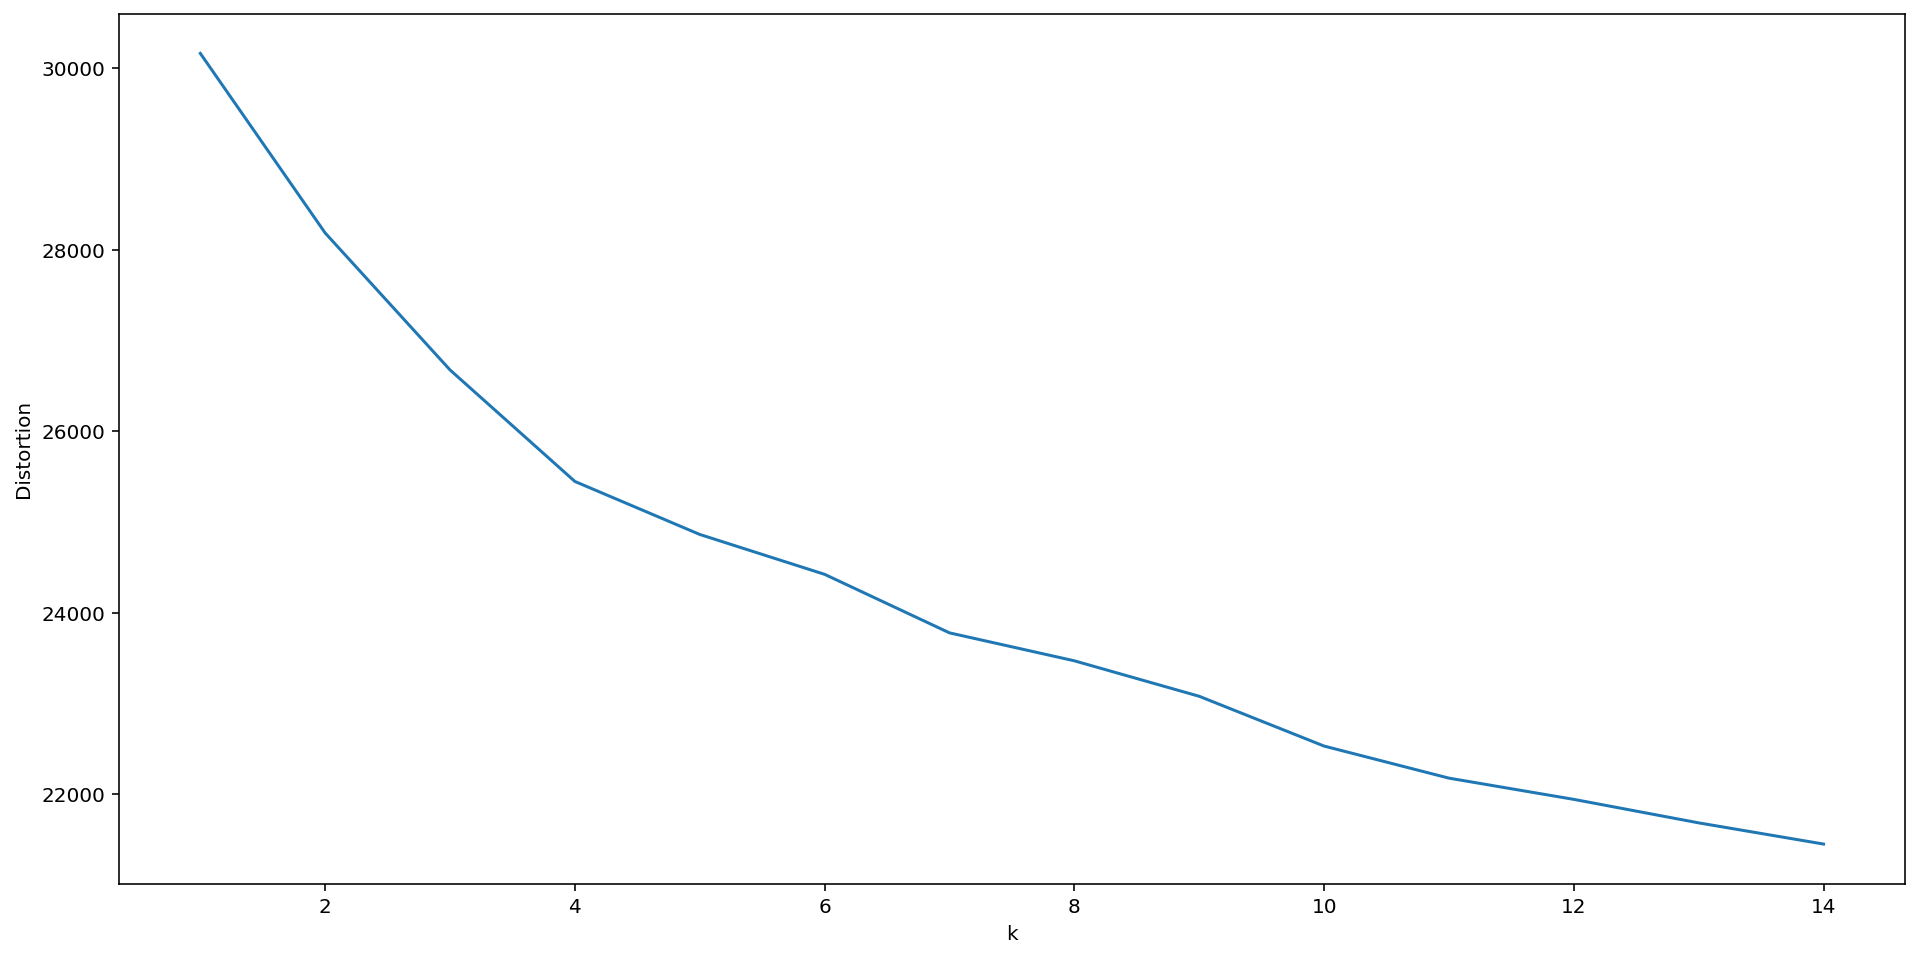

In [129]:
# Plot Distortion to Determine Elbow/Optimal k-value
plt.figure(figsize=(10,6))
plt.plot(range(1,15), distortions)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

# Elbow is around 6, some of these aisle are similar to each other so we'll use PCA
# to redefine features to better predict clusters

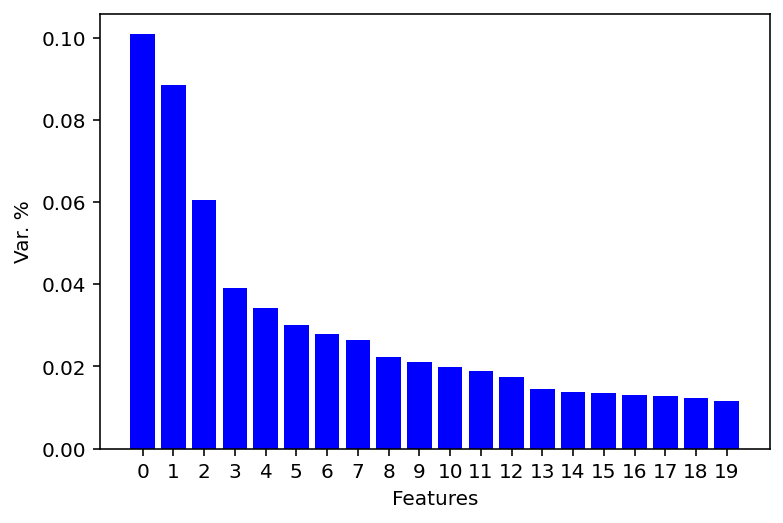

In [121]:
# PCA (PRINCIPAL COMPONENT ANALYSIS)
# Determine optimal n components
# Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(percent_df)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('Features')
plt.ylabel('Var. %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

# Variance drop off is at 3

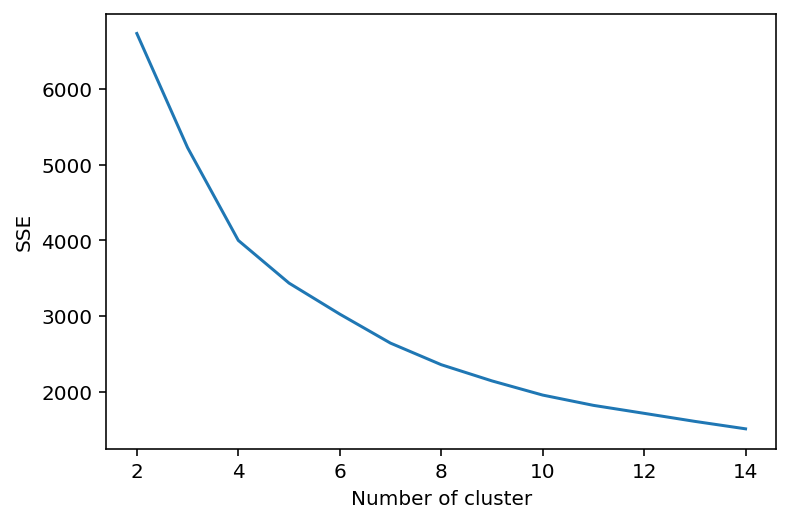

In [120]:
# Fit Model with k-mean clustering and PCA
sse = []
for k in range(2,15):
    kmeans = KMeans(n_clusters = k).fit(PCA_components[[0,1,2,3]])
    sse.append(kmeans.inertia_)
    
plt.figure()
plt.plot(sse.keys(), sse.values())
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

# 6 is still the optimal cluster # so we will continue with 3 components and 6 clusters.

In [133]:
# Fit model k-mean with 6 clusters, and PCA with 3 components
kmeans = KMeans(n_clusters = 6).fit(PCA_components[[0,1,2,3]])
cluster_label = kmeans.labels_

In [234]:
# Pivot Count For User and Aisle
percent_ct = pd.pivot_table(percent_user, values='count', index='user_id', columns = 'aisle', fill_value = 0 )
# Add Cluster Labels to Dataframe To Identify Customer Segment
percent_ct['cluster'] = kmeans.labels_
# Display preview
percent_ct.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [238]:
# Sum Count of Bought Products in Aisle
cluster_summary = percent_ct.groupby('cluster').sum()
cluster_summary = cluster_summary.reset_index(drop=False)
cluster_summary.head()

aisle,cluster,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0,54,598,21,26,704,142,906,62,28,...,1045,603,516,716,87,96,186,2797,57,3996
1,1,74,1729,32,32,1090,155,2147,131,28,...,1479,1028,1315,1547,63,113,252,3851,78,7138
2,2,7,33,0,1,15,12,61,10,3,...,82,180,10,12,37,33,25,7391,11,208
3,3,103,1290,73,66,3507,281,2578,144,40,...,3074,1924,1133,1989,309,221,457,7430,91,15631
4,4,821,3337,180,203,7862,897,7340,746,187,...,6360,5586,2135,4063,948,1150,1037,14942,851,27907


In [242]:
# Unpivot table 
df_unpivoted = cluster_summary.melt(id_vars=['cluster'], var_name='aisle', value_name='count')
df_unpivoted = df_unpivoted.sort_values('count', ascending = False)
df_unpivoted.head()

,cluster,aisle,count
319,1,fresh vegetables,83583
303,3,fresh fruits,74115
321,3,fresh vegetables,29797
301,1,fresh fruits,28179
802,4,yogurt,27907


In [269]:
# Calculate Cluster Aisle Sum/Total
cluster_ttl = pd.DataFrame(cluster_summary.sum(axis=1), columns=['total'])

# Determine Percentage of Aisle in Cluster
percent_cluster=[]
for i in range(6):
    filter_df = df_unpivoted[df_unpivoted['cluster'] == i].reset_index(drop=True)
    filter_df['percent'] = filter_df['count']/cluster_ttl['total'][i]
    percent_cluster.append(filter_df)

percent_cluster = pd.concat(percent_cluster)
percent_cluster.head()

,cluster,aisle,count,percent
0,0,packaged vegetables fruits,27537,0.200990
1,0,fresh fruits,14205,0.103681
2,0,fresh vegetables,12258,0.089470
3,0,yogurt,3996,0.029166
4,0,packaged cheese,3975,0.029013


<ipython-input-291-4e607cab7cbc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-291-4e607cab7cbc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-291-4e607cab7cbc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-291-4e607cab7cbc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-291-4e607cab7cbc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-291-4e607cab7cbc>:9: UserWarning: FixedFormatter should only be used together with Fi

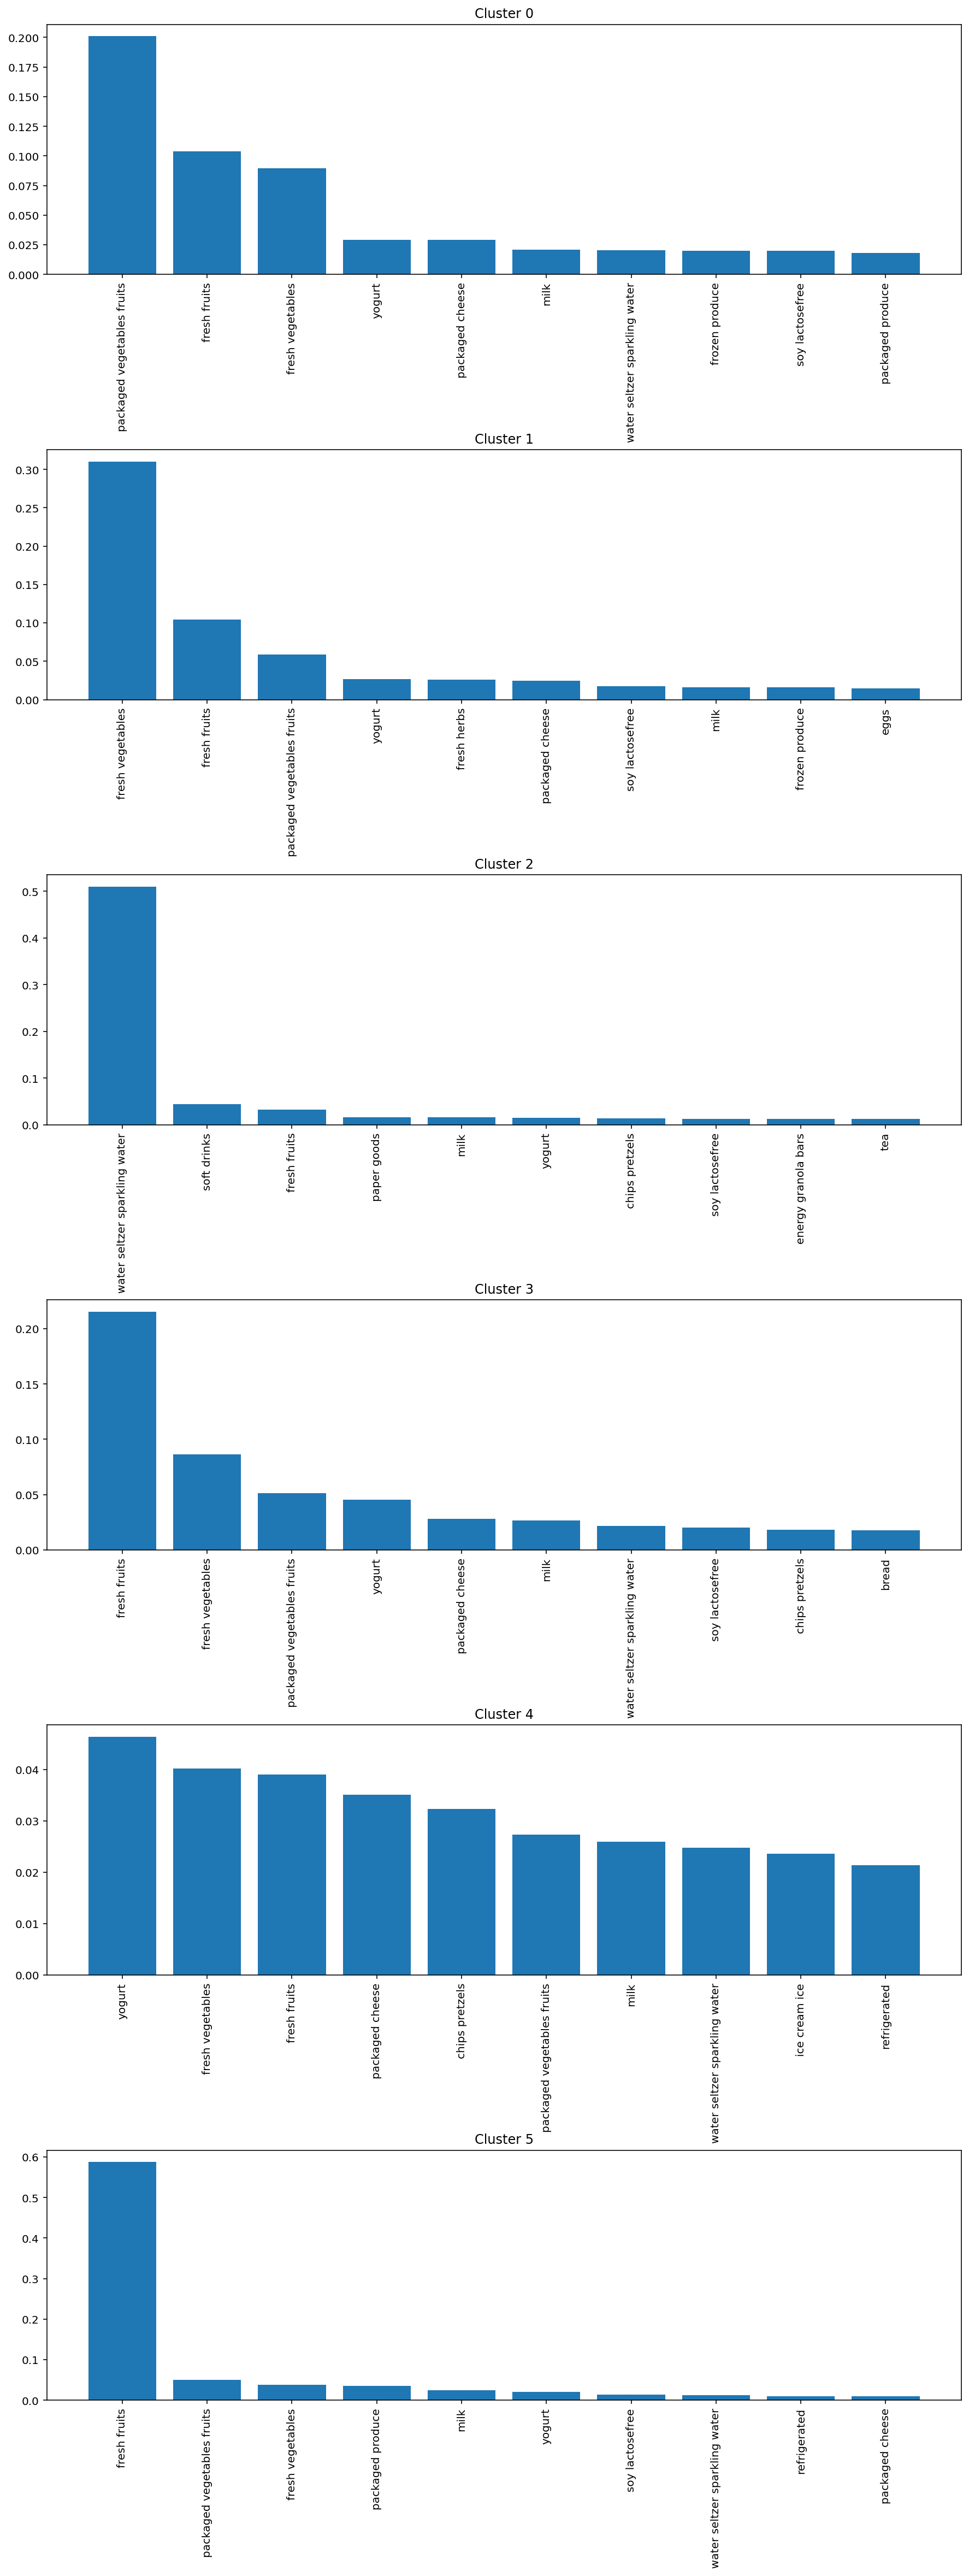

In [291]:
# Graph Top 10 Aisle in Clusters
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, figsize = (15,40))
fig.subplots_adjust(hspace=.7)
for i in range(6):
    filter_df = percent_cluster[percent_cluster['cluster'] == i].reset_index(drop=True)
    filter_df = filter_df.iloc[0:10]
    axs[i].bar(filter_df['aisle'], filter_df['percent'])
    axs[i].title.set_text(f'Cluster {i}')
    axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)

# 6 Clusters Define
# (1) Cluster 0: Mainly Packaged Vege, followed by Fresh Fruits
# (2) Cluster 1: Mainly Fresh Vege, followed by Fresh Fruits
# (3) Cluster 2: Mainly Sparking Water and Other Beverages Aisles
# (4) Cluster 3: Mainly Fresh Fruits, followed by Fresh Veges
# (5) Cluster 4: Mainly Yogurt, Balanced/Equal Aisle Distribution, followed by Fresh Vege/Fruits
# (6) Cluster 5: Heavy on Fresh Fruits, followed by Fresh/Packaged Vege

In [180]:
percent_ct = percent_ct.reset_index(drop=False)

In [183]:
top_cluster = percent_ct[['user_id','cluster']]

In [186]:
cluster_product = order_df[['user_id', 'product_id','product_name','aisle']].merge(top_cluster, on="user_id")

In [195]:
ab = cluster_product.groupby(['cluster','product_name'])['product_id'].count().reset_index(name='count')
ab = ab.sort_values('count',ascending=False)
#ab = ab.sort_values('cluster',ascending = True)
ab.head()

,cluster,product_name,count
39455,3,Banana,8328
39359,3,Bag of Organic Bananas,7261
52043,3,Organic Strawberries,5748
62343,4,Banana,4650
47312,3,Large Lemon,3671


In [196]:
ab[ab['cluster']==0]

,cluster,product_name,count
8731,0,Organic Baby Spinach,3271
8820,0,Organic Blueberries,1956
1041,0,Banana,1809
967,0,Bag of Organic Bananas,1761
10014,0,Organic Raspberries,1672
...,...,...,...
7425,0,Matcha Green Tea Powder,1
7423,0,Match Light Instant Charcoal Briquets,1
7422,0,Matar-Paneer,1
7421,0,Master's Best Winter Wheat Premium Bread,1


In [203]:
sorted(ab['cluster'].unique())

[0, 1, 2, 3, 4, 5]

In [218]:
# Sort Cluster
cluster_list = sorted(ab['cluster'].unique())
inital_df = ab[ab['cluster'] == 0][0:10]

for i in range(1, len(cluster_list)):
    top_df = ab[ab['cluster'] == i][0:10]
    inital_df = pd.concat([inital_df, top_df])

In [214]:
inital_df

,cluster,product_name,count
8731,0,Organic Baby Spinach,3271
8820,0,Organic Blueberries,1956
1041,0,Banana,1809
967,0,Bag of Organic Bananas,1761
10014,0,Organic Raspberries,1672
17206,1,Banana,3001
28161,1,Organic Zucchini,2726
25872,1,Organic Baby Spinach,2579
26572,1,Organic Garlic,2564
17118,1,Bag of Organic Bananas,2560


In [217]:
aisle_list = sorted(order_df['aisle'].unique())
aisle_list

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce',
 'canned jarred vegetables',
 'canned meals beans',
 'canned meat seafood',
 'cat food care',
 'cereal',
 'chips pretzels',
 'cleaning products',
 'cocoa drink mixes',
 'coffee',
 'cold flu allergy',
 'condiments',
 'cookies cakes',
 'crackers',
 'cream',
 'deodorants',
 'diapers wipes',
 'digestion',
 'dish detergents',
 'dog food care',
 'doughs gelatins bake mixes',
 'dry pasta',
 'eggs',
 'energy granola bars',
 'energy sports drinks',
 'eye ear care',
 'facial care',
 'feminine care',
 'first aid',
 'food storage',
 'fresh dips tapenades',
 'fresh fruits',
 'f